In [1]:
import os

import numpy as np
import tensorflow as tf

import plotting

from pinn import PINNModel
from models import model1

2024-10-06 21:50:47.699928: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 21:50:47.735455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 21:50:47.777440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 21:50:47.790459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 21:50:47.822819: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

### Params

In [3]:
grid_size = (50, 50)
plotting_grid_size = (200, 200)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)

EPOCHS = 3000
EPRINT = 500
LOSS = 1e-2  # 1e-4


if not os.path.isdir("../models"):
    os.mkdir("../models")


def koef_path(koef: int) -> str:
    return f"../models/koef={koef}.weights.h5"

In [4]:
def get_area(grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1], grid_size[0], dtype=np.float32)[1:-1]
    y = np.linspace(y_limits[0], y_limits[1], grid_size[1], dtype=np.float32)[1:-1]

    # FIXME: area inside points is in border??
    return mesh_to_pairs(np.meshgrid(x, y))


def get_border(border_grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1],
                    border_grid_size[0], dtype=np.float32)
    y = np.linspace(y_limits[0], y_limits[1],
                    border_grid_size[1], dtype=np.float32)
    x_first = np.full(border_grid_size[0], x[0])
    x_last = np.full(border_grid_size[0], x[-1])
    y_first = np.full(border_grid_size[1], y[0])
    y_last = np.full(border_grid_size[1], y[-1])
    border = np.concatenate((np.column_stack((x_first, x)), np.column_stack(
        (x_last, x)), np.column_stack((y, y_first))[1:-1], np.column_stack((y, y_last))[1:-1]))
    return border


def mesh_to_pairs(meshgrid: list[np.ndarray]):
    return np.column_stack((meshgrid[0].flatten(), meshgrid[1].flatten()))

In [6]:
area = get_area(grid_size, x_limits, y_limits)
border = get_border(border_grid_size, x_limits, y_limits)

model = PINNModel(model1(), optm = tf.keras.optimizers.Adam(learning_rate=0.001))
model.train(1, area, border, EPOCHS, LOSS, EPRINT)

AttributeError: 'function' object has no attribute 'compile'

In [12]:
# initial_weights = model.get_weights()
# area = get_area(grid_size, x_limits, y_limits)
# border = get_border(border_grid_size, x_limits, y_limits)

# koefs = np.linspace(0.1, 1, 100, dtype=np.float32)

# for i in koefs:
#     model.set_weights(initial_weights)
#     koef = i
#     path = koef_path(koef)

#     train_with_loss(model, optm, koef, area, border)
#     print(f"koef={koef}; Training ended successfully\n")

#     model.save_weights(path)
    # plotting.NNPlots.plotLoss(train_loss_record)

/home/c0c0nut/Projects/PINN_Puasson/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


koef=0.10000000149011612; Training ended successfully

koef=0.1090909093618393; Training ended successfully



KeyboardInterrupt: 

In [24]:
model.load_weights("../models/koef=2.weights.h5")

In [25]:
def real_u(area):
    area = np.array(area)
    if len(area.shape) >= 3:
        x = area[0]
        y = area[1]
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    else:
        return np.array([np.sin(np.pi * x) * np.sin(np.pi * y)  for x, y in area])

In [26]:
"""
Preparing usefull arrays for plotting and accuracy calculation
"""

# TODO: set area and border in different arrays
x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], plotting_grid_size[1])
x, y = np.meshgrid(x, y)
test_x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)
train_u = real_u((x, y))
true_u = real_u((test_x, test_y))
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = model.predict(np.array(pred_coord)).ravel().reshape(plotting_grid_size[0], plotting_grid_size[1])

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step


/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:79: UserWarning: The following kwargs were not used by contour: 'linestyle'
  real.contour(
/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:100: UserWarning: The following kwargs were not used by contour: 'linestyle'
  pred.contour(
/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:130: UserWarning: The following kwargs were not used by contour: 'linestyle'
  diff.contour(


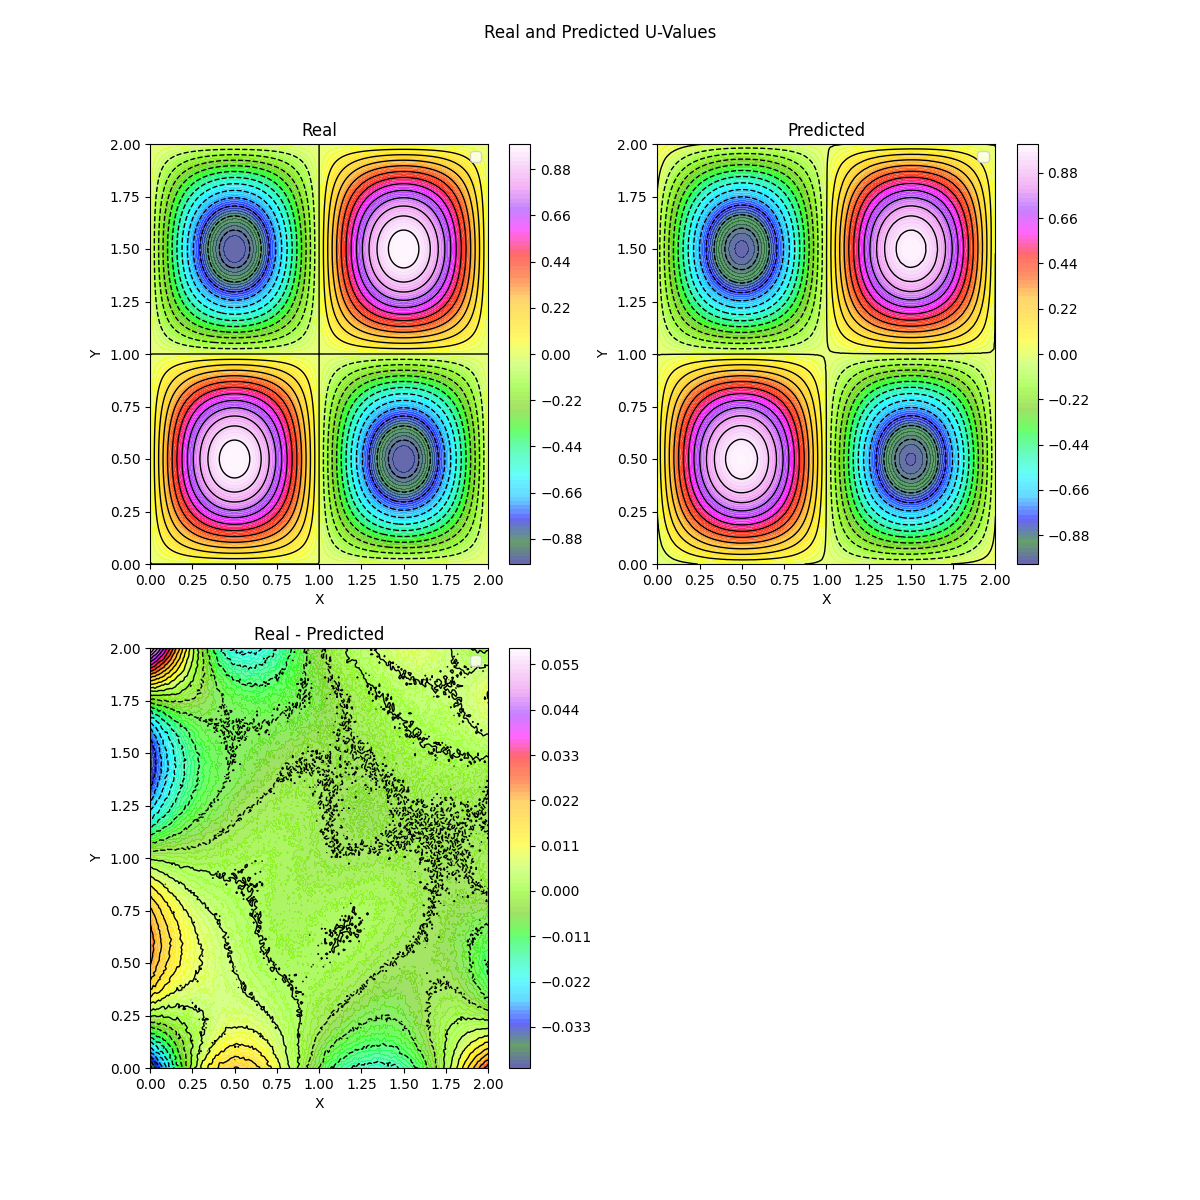

In [27]:
%matplotlib widget
plotter = plotting.NNPlots(test_x, test_y, true_u, x, y, pred_u, x_limits, y_limits)
# plotter.plot3d()
# plotter.plot2d_fix_x(3)

# cool cmaps: coolwarm(set as default), cool, gistncar, rainbow
plotter.plot2d_contour(color_map="gist_ncar", contour_levels=30)

# Accuracy calculation

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step
Error: 0.26532817339602865
Error: 1.864741325378418
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step
Error: 0.1110522281440446
Error: 1.3120062351226807
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step
Error: 0.004525904545914155
Error: 0.31279024481773376
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step
Error: 0.00014428221504731594
Error: 0.08147133886814117
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step
Error: 1.9449979368679392e-05
Error: 0.021425578743219376


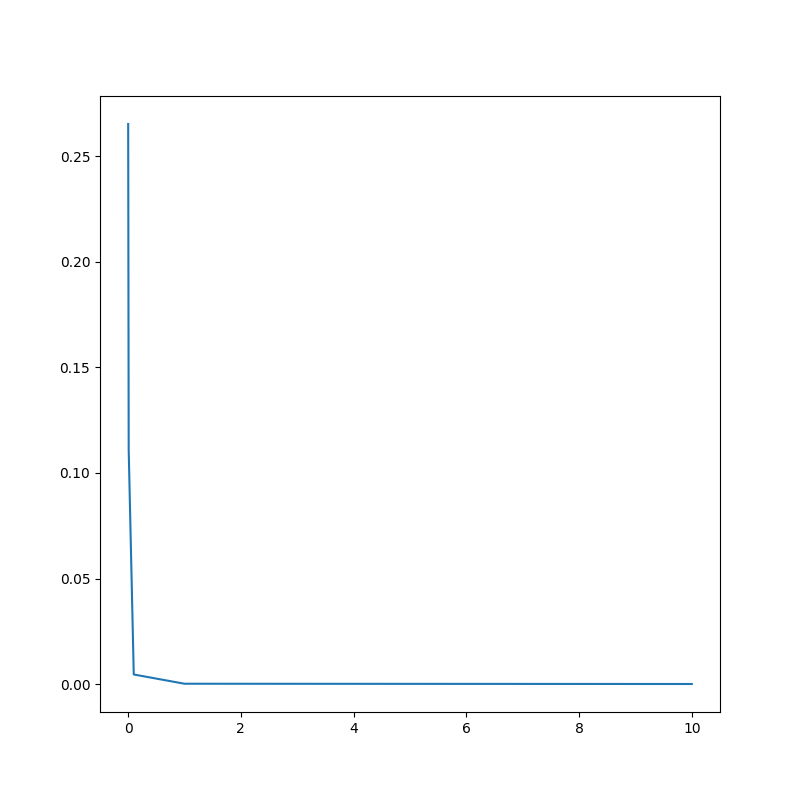

In [30]:
from accuracy import AccuracyCalc

errors_record = []

# 0 koef has bad accuracy)
for i in koefs[:-2]:
    # koef = print(koef_path(i))
    model.load_weights(koef_path(i))
    calc = AccuracyCalc(model, real_u, area=np.array(pred_coord))
    errors_record.append(calc.mse())
    print("Error:", calc.mse())
    print("Error:", calc.maxe())
    
# plt.plot(koefs, errors_record, label="Errors")
plotter.plot_error(koefs[:-2], errors_record)